In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

data = pd.read_csv('/content/gdrive/My Drive/capstone2/data/2021/oneik.csv')
data.head()

,date,close,open,high,low,vol
0,2000-04-24,5940,6070,6100,5800,409179
1,2000-04-25,5870,5700,6000,5610,249685
2,2000-04-26,5800,6150,6260,5650,391259
3,2000-04-27,5600,5650,5900,5400,205318
4,2000-04-28,5660,5700,5730,5570,224748


In [ ]:
features = ['close', 'open', 'high', 'low', 'vol']
stockPrice = data[features]
stockPrice.index = data['date']
stockPrice.head()

,close,open,high,low,vol
date,,,,,
2000-04-24,5940,6070,6100,5800,409179
2000-04-25,5870,5700,6000,5610,249685
2000-04-26,5800,6150,6260,5650,391259
2000-04-27,5600,5650,5900,5400,205318
2000-04-28,5660,5700,5730,5570,224748


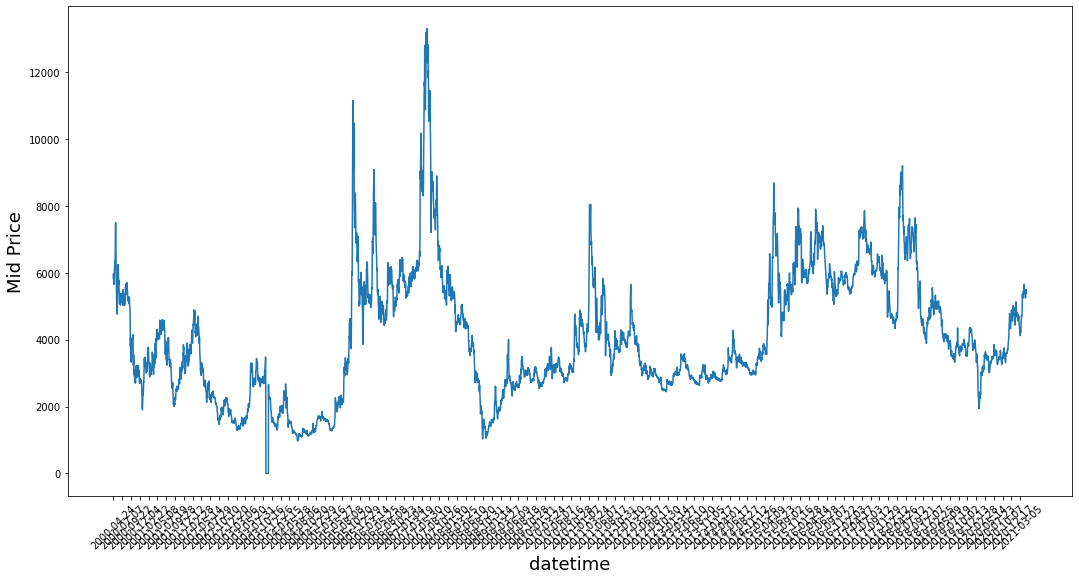

In [ ]:
plt.figure(figsize = (18,9))
df = stockPrice.copy()
plt.plot(df.index,(df['low']+df['high'])/2.0)
plt.xticks(df.iloc[::50,:].index,rotation=45)
plt.xlabel('datetime',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

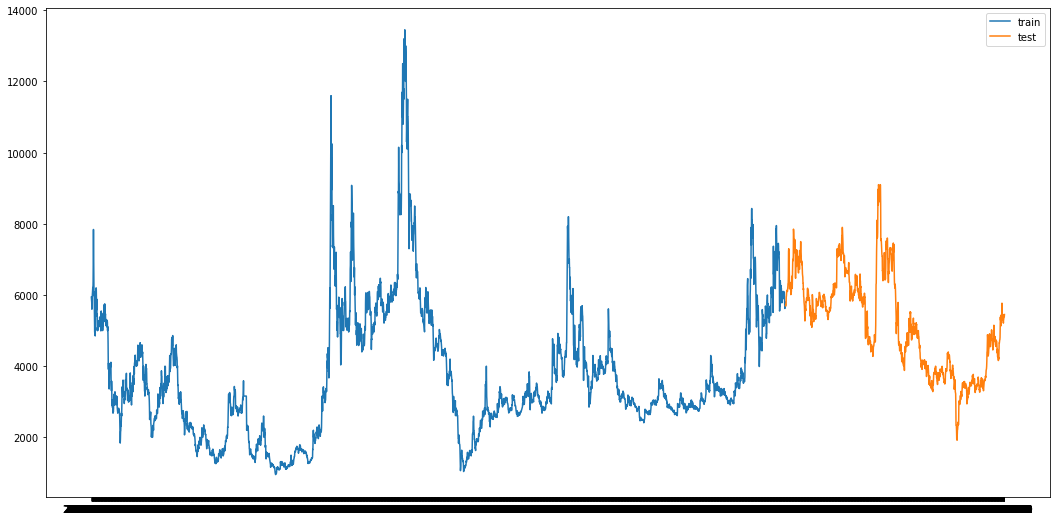

In [ ]:
stockPriceClose=stockPrice[['close']]
# 학습용 데이터와 테스트용 데이터로 분리
train_data=pd.DataFrame(stockPriceClose.loc[:'2016-04-01',['close']])
test_data=pd.DataFrame(stockPriceClose.loc['2016-04-01':,['close']])
# 분리된 데이터 
plt.figure(figsize = (18,9))
plt.plot(train_data)
plt.plot(test_data)
plt.legend(['train', 'test'])
plt.show()

In [ ]:
# 학습 데이터와 테스트 데이터(ndarray)를 데이터프레임으로 변형한다.
from sklearn.preprocessing import MinMaxScaler
total_data=pd.DataFrame(stockPriceClose.loc[:,['close']])

scaler = MinMaxScaler() 
total_data_sc=scaler.fit_transform(total_data)

total_sc_df=pd.DataFrame(total_data_sc, columns=['Scaled_0'], index=total_data.index)

# LSTM은 과거의 데이터를 기반으로 미래을 예측하는 모델이다. 
# 따라서, 과거 데이터를 몇 개 사용해서 예측할 지 정해야 한다. 여기서는 250개(1년)를 사용한다. 그리고 60개(3개월)을 예측한다.  
past_data = 120
pred_data = 60
for i in range(1, past_data + pred_data):
    total_sc_df['Scaled_{}'.format(i)]=total_sc_df['Scaled_0'].shift(i)

train_sc_df=pd.DataFrame(total_sc_df.loc[:'2016-04-01',:])
test_sc_df=pd.DataFrame(total_sc_df.loc['2016-04-01':,:])
print(test_sc_df)
#nan 값이 있는 로우를 삭제하고 X값과 Y값을 생성한다.
x_train=train_sc_df.dropna().drop([f'Scaled_{i}' for i in range(pred_data)], axis=1).loc[:,::-1]
y_train=train_sc_df.dropna()[[f'Scaled_{i}' for i in range(pred_data)]].loc[:,::-1]
print(x_train)
x_test=test_sc_df.dropna().drop([f'Scaled_{i}' for i in range(pred_data)], axis=1).loc[:,::-1]
y_test=test_sc_df.dropna()[[f'Scaled_{i}' for i in range(pred_data)]].loc[:,::-1]
print(y_test)

            Scaled_0  Scaled_1  Scaled_2  ...  Scaled_177  Scaled_178  Scaled_179
date                                      ...                                    
2016-04-01  0.379752  0.386955  0.387755  ...    0.470188    0.475790    0.445378
2016-04-04  0.378952  0.379752  0.386955  ...    0.458183    0.470188    0.475790
2016-04-05  0.382953  0.378952  0.379752  ...    0.459784    0.458183    0.470188
2016-04-06  0.382953  0.382953  0.378952  ...    0.457383    0.459784    0.458183
2016-04-07  0.399760  0.382953  0.382953  ...    0.488595    0.457383    0.459784
...              ...       ...       ...  ...         ...         ...         ...
2021-04-19  0.349340  0.348539  0.340536  ...    0.220088    0.222489    0.206883
2021-04-20  0.354142  0.349340  0.348539  ...    0.219288    0.220088    0.222489
2021-04-21  0.359744  0.354142  0.349340  ...    0.213685    0.219288    0.220088
2021-04-22  0.354942  0.359744  0.354142  ...    0.210884    0.213685    0.219288
2021-04-23  0.35

In [ ]:
print(test_sc_df.iloc[496,:])

Scaled_0      0.265706
Scaled_1      0.276511
Scaled_2      0.286915
Scaled_3      0.287715
Scaled_4      0.284914
                ...   
Scaled_175    0.537415
Scaled_176    0.537415
Scaled_177    0.531813
Scaled_178    0.501401
Scaled_179    0.506202
Name: 2018-04-10, Length: 180, dtype: float64


In [ ]:
# 대부분의 기계학습 모델은 데이터프레임 대신 ndarray구조를 입력 값으로 사용한다.
# ndarray로 변환한다.
x_train=x_train.values
x_test=x_test.values

y_train=y_train.values
y_test=y_test.values

# LSTM 모델에 맞게 데이터 셋 변형
x_train_t = x_train.reshape(x_train.shape[0], past_data,1)
x_test_t = x_test.reshape(x_test.shape[0], past_data, 1)

In [ ]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 


with tf.device('/device:GPU:0'):
    K.clear_session() 
    # Sequeatial Model
    model = Sequential() 
    # 첫번째 LSTM 레이어
    model.add(LSTM(past_data,return_sequences=False, input_shape=(past_data, 1))) 
    # 예측값 60개
    model.add(Dense(pred_data, activation='linear')) 
    # 손실함수 지정 - 예측 값과 실제 값의 차이를 계산한다. MSE가 사용된다. 
    # 최적화기 지정 - adam을 사용한다.
    model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120)               58560     
_________________________________________________________________
dense (Dense)                (None, 60)                7260      
Total params: 65,820
Trainable params: 65,820
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 손실 값(loss)를 모니터링해서 성능이 더이상 좋아지지 않으면 epoch를 중단한다.
# vervose=1은 화면에 출력
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

#epochs는 훈련 반복 횟수를 지정하고 batch_size는 한 번 훈련할 때 입력되는 데이터 크기를 지정한다.
model.fit(x_train_t, y_train, epochs=500,
          batch_size=64, verbose=1, callbacks=[early_stop])

Epoch 1/500
59/59 [==============================] - 33s 9ms/step - loss: 0.0347
Epoch 2/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0079
Epoch 3/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 4/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 5/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 6/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0064
Epoch 7/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0067
Epoch 8/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0069
Epoch 9/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 10/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 11/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0059
Epoch 12/500
59/59 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 13/500
59/59 [================

                  0         1         2   ...        57        58        59
date                                      ...                              
2016-04-01  0.426170  0.418167  0.467787  ...  0.387755  0.386955  0.379752
2016-04-04  0.418167  0.467787  0.503001  ...  0.386955  0.379752  0.378952
2016-04-05  0.467787  0.503001  0.513405  ...  0.379752  0.378952  0.382953
2016-04-06  0.503001  0.513405  0.552621  ...  0.378952  0.382953  0.382953
2016-04-07  0.513405  0.552621  0.543017  ...  0.382953  0.382953  0.399760
...              ...       ...       ...  ...       ...       ...       ...
2021-04-19  0.298519  0.308924  0.314526  ...  0.340536  0.348539  0.349340
2021-04-20  0.308924  0.314526  0.335734  ...  0.348539  0.349340  0.354142
2021-04-21  0.314526  0.335734  0.321329  ...  0.349340  0.354142  0.359744
2021-04-22  0.335734  0.321329  0.312925  ...  0.354142  0.359744  0.354942
2021-04-23  0.321329  0.312925  0.299320  ...  0.359744  0.354942  0.359744

[1244 rows 

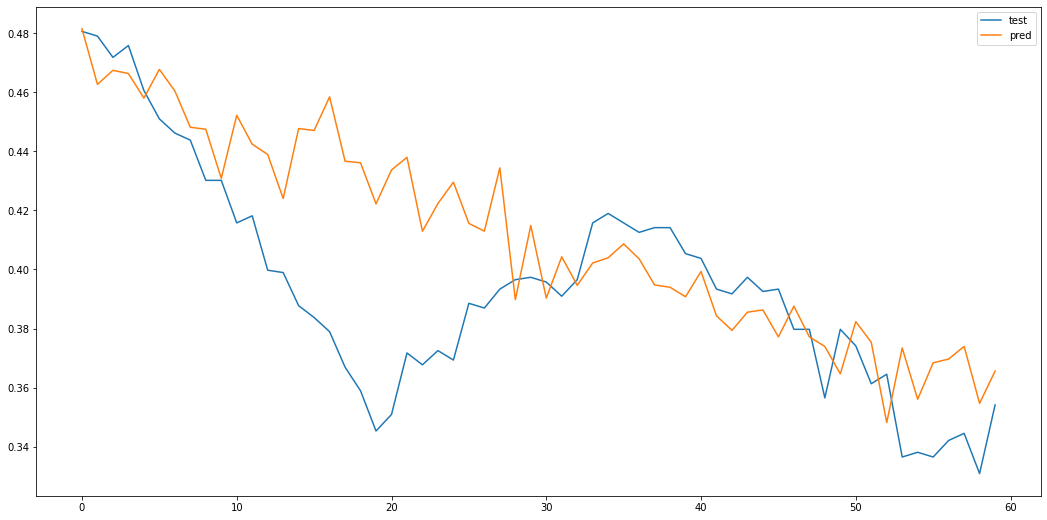

In [ ]:
#테스트의 Y값(실측값) 과 예측값을 비교한다.
y_pred = model.predict(x_test_t)
t_df=test_sc_df.dropna()

y_test_df=pd.DataFrame([y_test][0], index=t_df.index)
y_pred_df=pd.DataFrame([y_pred][0], index=t_df.index)
print(y_test_df)
correct = 0
real_up = 0
real_down = 0
correct_up = 0
correct_down = 0
size = len(y_test_df)
for i in range(size):
    test = y_test_df.iloc[i][pred_data - 1] - y_test_df.iloc[i][0]
    pred = y_pred_df.iloc[i][pred_data - 1] - y_pred_df.iloc[i][0]
    if test <= 0:
        real_down += 1
        if pred <= 0:
            correct += 1
            correct_down += 1
    else:
        real_up += 1
        if pred > 0:
            correct += 1
            correct_up += 1
print('acc:', round(correct / size * 100, 2), '%')
print('up_acc:   ', round(correct_up / real_up * 100, 2), '%', f' {correct_up} / {real_up}')
print('down_acc: ', round(correct_down / real_down * 100, 2), '%', f' {correct_down} / {real_down}')
plt.figure(figsize = (18,9))
plt.plot(y_test_df.iloc[150])
plt.plot(y_pred_df.iloc[150])
plt.legend(['test','pred'])
plt.show()